In [36]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    device_ids = list(range(torch.cuda.device_count()))
    print(f'Available GPUs: {device_ids}')
else:
    print('No GPU available. Training will be performed on CPU.')


Available GPUs: [0, 1]


In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch.utils.data as data
import os

os.chdir('/home/tm_ba/Desktop/Bachelorarbeit_code')

In [38]:
# Load the dataset
df = pd.read_csv("csv_new/processed_Trajectories.csv")
df.head()


,Frame,shoulder:X,shoulder:Y,shoulder:Z,elbow:X,elbow:Y,elbow:Z,wrist:X,wrist:Y,wrist:Z,ThumbTip:X,ThumbTip:Y,ThumbTip:Z,Sequence
0,1,424.563679,31.445054,632.763792,437.255669,95.056137,303.741040,326.800612,202.974780,98.728533,208.189711,226.987415,58.566404,0
1,2,424.295767,31.463165,632.810122,436.349315,95.551888,303.887265,324.416997,203.830784,100.116664,205.696950,226.350274,58.793938,0
2,3,424.058731,31.496611,632.856757,435.518783,96.208076,304.060796,321.978571,204.765964,101.315481,203.130669,225.790438,59.283324,0
3,4,423.839756,31.552288,632.884049,434.717062,96.974342,304.236887,319.504761,205.752253,102.392088,200.513515,225.286090,59.932349,0
4,5,423.629020,31.633001,632.880829,433.908156,97.811531,304.399760,317.010496,206.768091,103.398043,197.863597,224.820703,60.664590,0


In [39]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29040 entries, 0 to 29039
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Frame       29040 non-null  int64  
 1   shoulder:X  29040 non-null  float64
 2   shoulder:Y  29040 non-null  float64
 3   shoulder:Z  29040 non-null  float64
 4   elbow:X     29040 non-null  float64
 5   elbow:Y     29040 non-null  float64
 6   elbow:Z     29040 non-null  float64
 7   wrist:X     29040 non-null  float64
 8   wrist:Y     29040 non-null  float64
 9   wrist:Z     29040 non-null  float64
 10  ThumbTip:X  29040 non-null  float64
 11  ThumbTip:Y  29040 non-null  float64
 12  ThumbTip:Z  29040 non-null  float64
 13  Sequence    29040 non-null  int64  
dtypes: float64(12), int64(2)
memory usage: 3.1 MB
None
              Frame    shoulder:X    shoulder:Y    shoulder:Z       elbow:X  \
count  29040.000000  29040.000000  29040.000000  29040.000000  29040.000000   
mean     296.844043  

In [40]:
from sklearn.preprocessing import MinMaxScaler

# List of coordinate columns
coord_cols = df.columns[1:-1]  # Exclude 'Frame' and 'Sequence'

# Initialize scaler
scaler = MinMaxScaler()

# Fit and transform the data
df[coord_cols] = scaler.fit_transform(df[coord_cols])


In [41]:
# Group the data by 'Sequence' and collect sequences
sequences = []
sequence_ids = df['Sequence'].unique()

for seq_id in sequence_ids:
    seq_data = df[df['Sequence'] == seq_id]
    # Drop unnecessary columns
    seq_data = seq_data[coord_cols].values
    sequences.append(seq_data)

In [42]:
# Split sequences into train, validation, and test sets
train_seqs, temp_seqs = train_test_split(sequences, test_size=0.3, random_state=42)
val_seqs, test_seqs = train_test_split(temp_seqs, test_size=0.5, random_state=42)

print(f'Number of training sequences: {len(train_seqs)}')
print(f'Number of validation sequences: {len(val_seqs)}')
print(f'Number of test sequences: {len(test_seqs)}')

Number of training sequences: 35
Number of validation sequences: 8
Number of test sequences: 8


In [43]:
class MotionDataset(data.Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        # Convert to tensors
        seq = torch.tensor(seq, dtype=torch.float32)
        # Input sequence (all except last time step)
        input_seq = seq[:-1]
        # Target sequence (all except first time step)
        target_seq = seq[1:]
        return input_seq, target_seq


In [44]:
batch_size = 16

train_dataset = MotionDataset(train_seqs)
val_dataset = MotionDataset(val_seqs)
test_dataset = MotionDataset(test_seqs)

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: x)
val_loader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: x)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: x)


In [45]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    inputs = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    # Pad sequences
    inputs_padded = pad_sequence(inputs, batch_first=True)
    targets_padded = pad_sequence(targets, batch_first=True)
    # Create masks
    input_lengths = torch.tensor([len(seq) for seq in inputs])
    target_lengths = torch.tensor([len(seq) for seq in targets])
    return inputs_padded, targets_padded, input_lengths, target_lengths


In [46]:
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


### Step 1: Data Normalization

In [47]:
import torch.nn as nn
import torch.nn.functional as F


In [49]:
from Code.preprocessing.TransformerModel import *

In [52]:
input_dim = len(coord_cols)  # Should be 12 coordinates
output_dim = len(coord_cols)  # Should be 12 coordinates
hidden_dim = 256
num_layers = 4
num_heads = 8
dropout = 0.1

model = MotionTransformerModel(
    input_dim=input_dim,
    output_dim=output_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    num_heads=num_heads,
    dropout=dropout
)

# Move model to GPUs
if torch.cuda.is_available():
    model = nn.DataParallel(model)  # Utilize multiple GPUs
    model = model.cuda()

print(input_dim)

12


/home/tm_ba/miniconda3/envs/BA/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


### Step 2: Model Implementation

In [53]:
def custom_loss_function(prediction, target, lengths):
    # Calculate position loss (MSE)
    position_loss = F.mse_loss(prediction, target, reduction='mean')
    
    # Calculate velocity (difference between consecutive positions)
    pred_velocity = prediction[:, 1:] - prediction[:, :-1]
    target_velocity = target[:, 1:] - target[:, :-1]
    
    # Velocity loss
    velocity_loss = F.mse_loss(pred_velocity, target_velocity, reduction='mean')
    
    # Calculate acceleration (difference between consecutive velocities)
    pred_acceleration = pred_velocity[:, 1:] - pred_velocity[:, :-1]
    target_acceleration = target_velocity[:, 1:] - target_velocity[:, :-1]
    
    # Acceleration loss
    acceleration_loss = F.mse_loss(pred_acceleration, target_acceleration, reduction='mean')
    
    # Total loss
    total_loss = position_loss + velocity_loss + acceleration_loss
    return total_loss


In [54]:
def custom_loss_function(prediction, target, lengths):
    # Initialize losses
    position_loss = 0.0
    velocity_loss = 0.0
    acceleration_loss = 0.0
    batch_size = prediction.size(0)
    
    for i in range(batch_size):
        seq_len = lengths[i]
        pred_seq = prediction[i, :seq_len]
        target_seq = target[i, :seq_len]
        
        # Position loss
        position_loss += F.mse_loss(pred_seq, target_seq, reduction='mean')
        
        # Velocity loss
        if seq_len > 1:
            pred_velocity = pred_seq[1:] - pred_seq[:-1]
            target_velocity = target_seq[1:] - target_seq[:-1]
            velocity_loss += F.mse_loss(pred_velocity, target_velocity, reduction='mean')
        
        # Acceleration loss
        if seq_len > 2:
            pred_acceleration = pred_velocity[1:] - pred_velocity[:-1]
            target_acceleration = target_velocity[1:] - target_velocity[:-1]
            acceleration_loss += F.mse_loss(pred_acceleration, target_acceleration, reduction='mean')
    
    # Average losses
    position_loss /= batch_size
    velocity_loss /= batch_size
    acceleration_loss /= batch_size
    
    total_loss = position_loss + velocity_loss + acceleration_loss
    return total_loss


### Step 3: Custom Loss Function

In [55]:
import torch.optim as optim

learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


### Step 4: Model Training

In [56]:
def train_epoch(model, dataloader, optimizer):
    model.train()
    total_loss = 0.0
    for batch in dataloader:
        inputs, targets, input_lengths, target_lengths = batch
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            targets = targets.cuda()
            input_lengths = input_lengths.cuda()
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = custom_loss_function(outputs, targets, input_lengths)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss


In [57]:
def validate_epoch(model, dataloader):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch in dataloader:
            inputs, targets, input_lengths, target_lengths = batch
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                targets = targets.cuda()
                input_lengths = input_lengths.cuda()
            
            outputs = model(inputs)
            loss = custom_loss_function(outputs, targets, input_lengths)
            total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss


In [58]:
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch(model, train_loader, optimizer)
    val_loss = validate_epoch(model, val_loader)
    scheduler.step()
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')


Epoch 1/50, Training Loss: 0.5531, Validation Loss: 0.0803
Epoch 2/50, Training Loss: 0.2393, Validation Loss: 0.1231
Epoch 3/50, Training Loss: 0.2355, Validation Loss: 0.0772
Epoch 4/50, Training Loss: 0.1733, Validation Loss: 0.0425
Epoch 5/50, Training Loss: 0.1431, Validation Loss: 0.0488
Epoch 6/50, Training Loss: 0.1457, Validation Loss: 0.0575
Epoch 7/50, Training Loss: 0.1430, Validation Loss: 0.0453
Epoch 8/50, Training Loss: 0.1285, Validation Loss: 0.0324
Epoch 9/50, Training Loss: 0.1153, Validation Loss: 0.0302
Epoch 10/50, Training Loss: 0.1121, Validation Loss: 0.0302
Epoch 11/50, Training Loss: 0.1096, Validation Loss: 0.0298
Epoch 12/50, Training Loss: 0.1097, Validation Loss: 0.0292
Epoch 13/50, Training Loss: 0.1095, Validation Loss: 0.0283
Epoch 14/50, Training Loss: 0.1143, Validation Loss: 0.0275
Epoch 15/50, Training Loss: 0.1125, Validation Loss: 0.0269
Epoch 16/50, Training Loss: 0.1072, Validation Loss: 0.0264
Epoch 17/50, Training Loss: 0.1047, Validation Lo

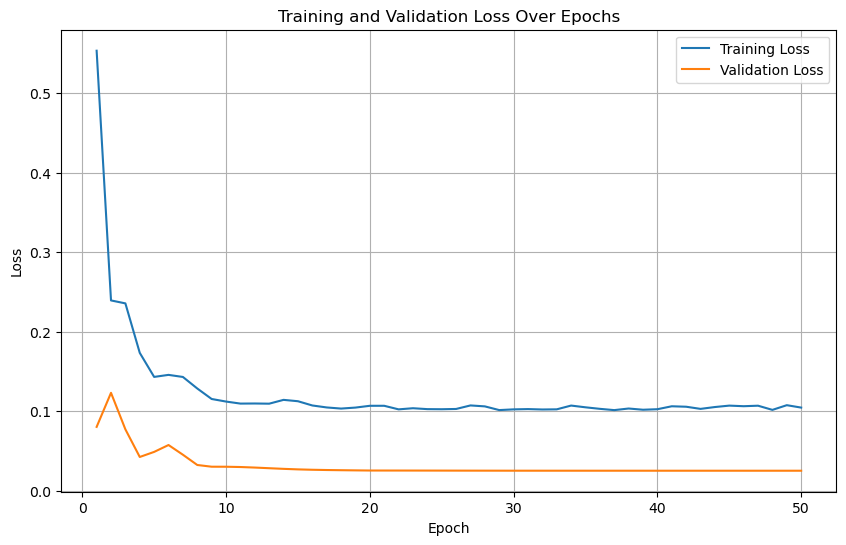

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [60]:
torch.save(model.state_dict(), 'motion_transformer_model.pth')


### Step 5: Evaluation and Fine-Tuning

In [61]:
test_loss = validate_epoch(model, test_loader)
print(f'Test Loss: {test_loss:.4f}')


Test Loss: 0.0426


In [62]:
def plot_predictions(model, dataset, index=0):
    model.eval()
    inputs, targets = dataset[index]
    inputs = inputs.unsqueeze(0)  # Add batch dimension
    if torch.cuda.is_available():
        inputs = inputs.cuda()
    with torch.no_grad():
        outputs = model(inputs)
    outputs = outputs.squeeze(0).cpu().numpy()
    targets = targets.numpy()
    
    time_steps = np.arange(outputs.shape[0])
    plt.figure(figsize=(12, 8))
    for i in range(outputs.shape[1]):
        plt.plot(time_steps, targets[:, i], label=f'Target {i}')
        plt.plot(time_steps, outputs[:, i], label=f'Predicted {i}', linestyle='--')
    plt.xlabel('Time Step')
    plt.ylabel('Normalized Coordinate Value')
    plt.title('Model Predictions vs. Targets')
    plt.legend()
    plt.show()


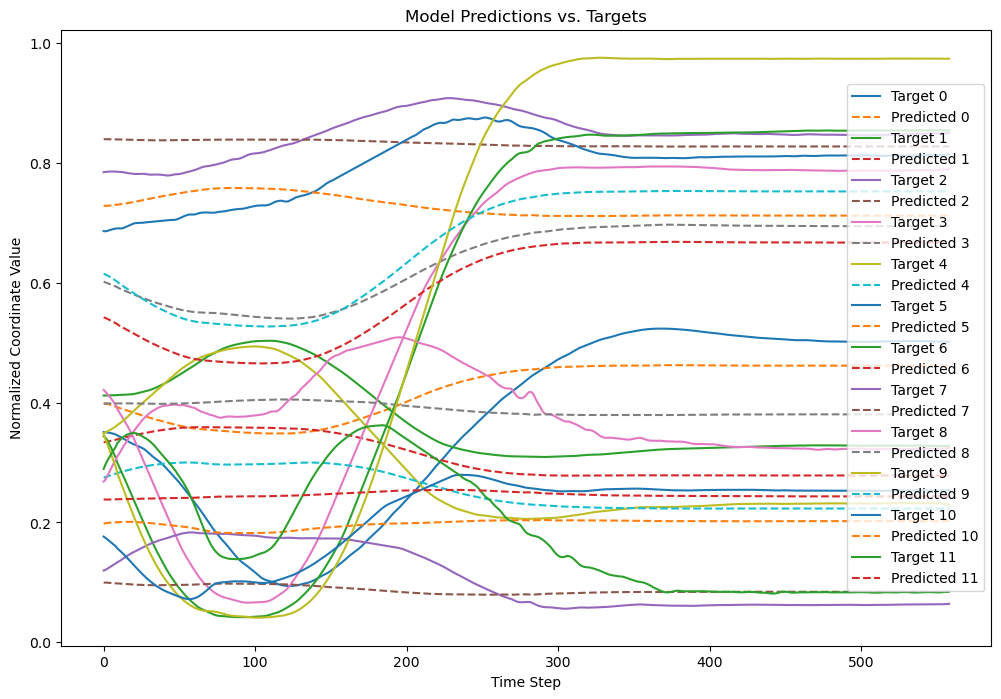

In [63]:
# Plot predictions for a sample from the test dataset
plot_predictions(model, test_dataset, index=0)


In [116]:
!jupyter nbconvert --to script Code/preprocessing/preprocess.ipynb

[NbConvertApp] Converting notebook Code/preprocessing/preprocess.ipynb to script
[NbConvertApp] Writing 15289 bytes to Code/preprocessing/preprocess.py
